# Car Breakdown – Exploratory Data Analysis (EDA)

## Objective
Understand the factors influencing vehicle breakdown within the next 30 days.


Team 7

## 1. Import libraries


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
train = pd.read_csv("train_CarBreakDown.csv")
test = pd.read_csv("test_CarBreakDown.csv")
pd.set_option('display.max_columns', None)


## 2. Load the dataset


In [14]:
train.shape
train.info()
train.head()


<class 'pandas.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1050 non-null   int64  
 1   vehicle_brand              1029 non-null   str    
 2   vehicle_age_years          1034 non-null   float64
 3   mileage_km                 1033 non-null   float64
 4   engine_hours               1035 non-null   float64
 5   last_service_km_ago        1040 non-null   float64
 6   oil_quality_pct            1014 non-null   float64
 7   avg_trip_length_km         1038 non-null   float64
 8   weather_exposure           1037 non-null   str    
 9   fuel_type                  1036 non-null   str    
 10  cleanliness_score          995 non-null    float64
 11  driver_satisfaction_score  1037 non-null   float64
 12  tyre_type                  1033 non-null   str    
 13  breakdown_next_30_days     1050 non-null   int64  
dtypes: 

,id,vehicle_brand,vehicle_age_years,mileage_km,engine_hours,last_service_km_ago,oil_quality_pct,avg_trip_length_km,weather_exposure,fuel_type,cleanliness_score,driver_satisfaction_score,tyre_type,breakdown_next_30_days
0,959,Toyota,20.0,494744.972722,9700.481467,1672.048445,61.664556,30.362090,high,petrol,68.117833,8.559011,NaN,0
1,804,Toyota,0.0,38376.684834,1650.726428,21.269170,23.370666,2.500801,high,hybrid,69.294736,9.838274,NaN,0
2,1304,Hyundai,1.0,188558.432414,6678.958321,11726.320455,25.491428,41.692205,medium,hybrid,47.223966,5.842726,winter,0
3,268,Toyota,5.0,92828.113285,2986.923461,1845.744691,54.060416,6.464345,high,diesel,72.246829,4.719607,winter,0
4,47,NaN,10.0,118366.394287,4222.193011,12551.181627,65.766074,47.159242,low,diesel,77.368891,6.724967,winter,0


### Interpretation

The dataset contains vehicle characteristics and maintenance information.
The target variable is `breakdown_next_30_days`.


## 3. Target Variable Analysis


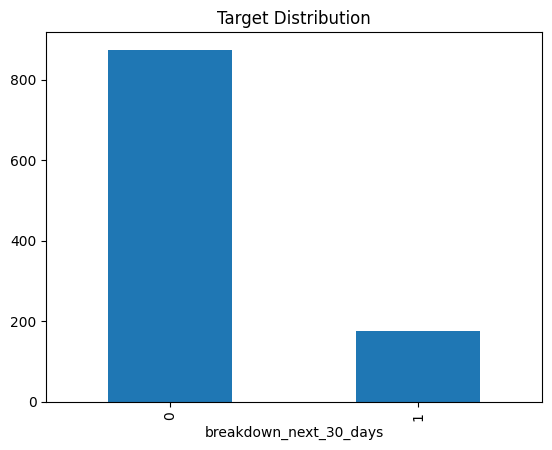

In [15]:
train["breakdown_next_30_days"].value_counts()
train["breakdown_next_30_days"].value_counts(normalize=True)
train["breakdown_next_30_days"].value_counts().plot(kind="bar")
plt.title("Target Distribution")
plt.show()


### Insight 1 – Class Imbalance

Approximately 84% of vehicles do not break down,
while 16% experience a breakdown.

This indicates class imbalance.
Accuracy alone will not be sufficient for evaluation.


## 4. Baseline Model


In [16]:
baseline_accuracy = train["breakdown_next_30_days"].value_counts(normalize=True).max()
baseline_accuracy


np.float64(0.8323809523809523)

### Insight 2 – Baseline

If we always predict "No Breakdown",
the model would achieve ~84% accuracy.

Any ML model must outperform this baseline.

## 5. Feature Types

In [20]:
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object', 'string']).columns.tolist()

numerical_cols.remove("breakdown_next_30_days")

print("Numerical:", numerical_cols)
print("Categorical:", categorical_cols)

Numerical: ['id', 'vehicle_age_years', 'mileage_km', 'engine_hours', 'last_service_km_ago', 'oil_quality_pct', 'avg_trip_length_km', 'cleanliness_score', 'driver_satisfaction_score']
Categorical: ['vehicle_brand', 'weather_exposure', 'fuel_type', 'tyre_type']


## 6. Numerical Feature Distributions


#### 6.1 Correlation

In [29]:
target = "breakdown_next_30_days"

numeric = train.select_dtypes(include=["int64", "float64"])
corr_with_target = numeric.corr()[target].sort_values(ascending=False)

corr_with_target = corr_with_target.drop(target)

if "id" in corr_with_target.index:
    corr_with_target = corr_with_target.drop("id")

corr_with_target

print("Top positive correlations (higher value -> more breakdown):")
print(corr_with_target.head(3))

print("\nTop negative correlations (higher value -> less breakdown):")
print(corr_with_target.tail(3))


Top positive correlations (higher value -> more breakdown):
vehicle_age_years      0.138214
last_service_km_ago    0.067742
engine_hours           0.053000
Name: breakdown_next_30_days, dtype: float64

Top negative correlations (higher value -> less breakdown):
avg_trip_length_km   -0.013303
cleanliness_score    -0.027467
oil_quality_pct      -0.083499
Name: breakdown_next_30_days, dtype: float64


### Insight 3 – Numerical Correlation


Vehicle age shows the strongest positive relationship with breakdown.
Older vehicles are more likely to fail.

Maintenance-related variables such as distance since last service
and engine hours also contribute, but the effect is moderate.

Oil quality shows a negative relationship, meaning better oil condition
is associated with lower breakdown probability.

Overall, correlations are weak.
This indicates that breakdown risk is influenced by multiple combined factors,
rather than a single dominant variable.


#### 6.2 Vehicle Age

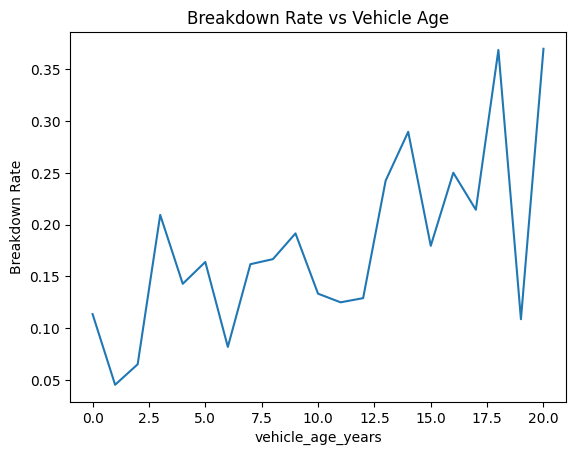

In [22]:
train.groupby("vehicle_age_years")["breakdown_next_30_days"].mean().plot()
plt.title("Breakdown Rate vs Vehicle Age")
plt.ylabel("Breakdown Rate")
plt.show()


Older vehicles show higher breakdown probability.

#### 6.3 Service Distance

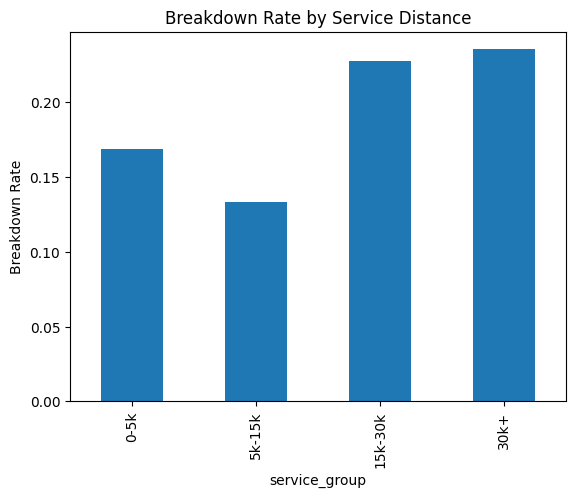

In [24]:
train["service_group"] = pd.cut(
    train["last_service_km_ago"],
    bins=[0, 5000, 15000, 30000, 50000],
    labels=["0-5k", "5k-15k", "15k-30k", "30k+"]
)

train.groupby("service_group")["breakdown_next_30_days"].mean().plot(kind="bar")
plt.title("Breakdown Rate by Service Distance")
plt.ylabel("Breakdown Rate")
plt.show()


Vehicles serviced within the last 5000 km
have the lowest breakdown rate.

As the distance since last service increases,
the probability of failure also increases.

This confirms that maintenance timing plays
an important role in vehicle reliability.

#### 6.4 Oil Quality

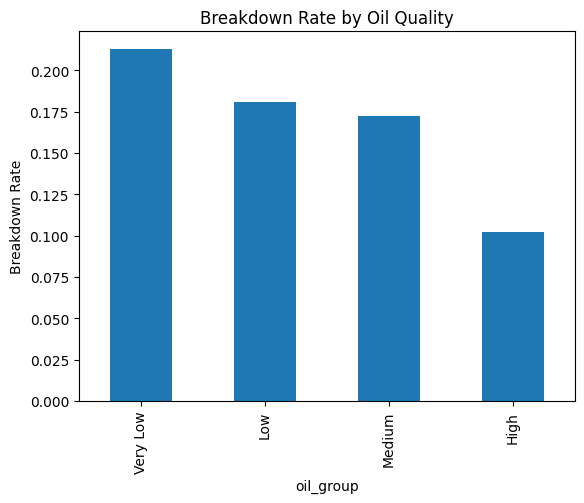

In [25]:
train["oil_group"] = pd.cut(
    train["oil_quality_pct"],
    bins=[0, 40, 60, 80, 100],
    labels=["Very Low", "Low", "Medium", "High"]
)

train.groupby("oil_group")["breakdown_next_30_days"].mean().plot(kind="bar")
plt.title("Breakdown Rate by Oil Quality")
plt.ylabel("Breakdown Rate")
plt.show()


Vehicles with very low oil quality
show the highest breakdown probability.

Better oil condition is associated
with lower mechanical failure risk.

This indicates that lubrication quality
directly affects engine reliability.

## 7. Categorical Feature Analysis


### Brand

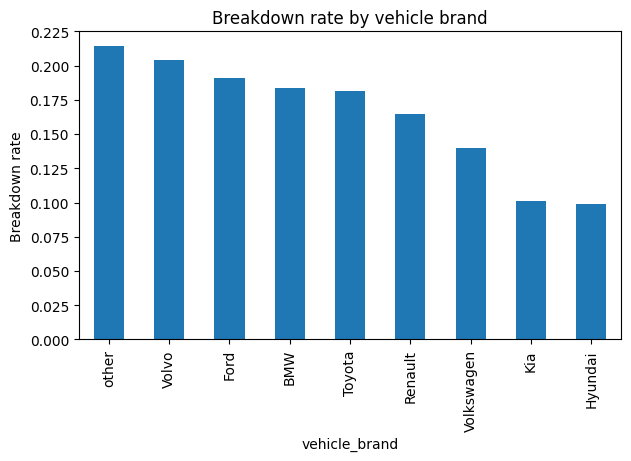

In [26]:
target = "breakdown_next_30_days"

brand_breakdown = (
    train
    .groupby("vehicle_brand")[target]
    .mean()
    .sort_values(ascending=False)
)

brand_breakdown.plot(kind="bar", figsize=(7,4))
plt.title("Breakdown rate by vehicle brand")
plt.ylabel("Breakdown rate")
plt.show()


Some brands (e.g., Volvo and Ford)
show higher breakdown rates.

Others (e.g., Hyundai and Kia)
show noticeably lower rates.

Brand appears to moderately influence reliability,
although it is not the dominant factor.

### Weather Exposure

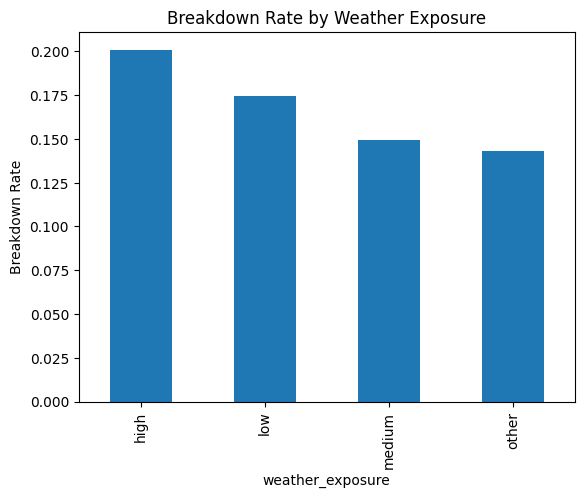

In [27]:
train.groupby("weather_exposure")["breakdown_next_30_days"].mean().plot(kind="bar")
plt.title("Breakdown Rate by Weather Exposure")
plt.ylabel("Breakdown Rate")
plt.show()


Vehicles exposed to all-season conditions show higher breakdown rates.
Environmental exposure contributes to mechanical stress.


## Final EDA Summary

Breakdown is a rare event (~16%).

Vehicle age, service distance, and oil quality
are the strongest influencing factors.

Brand and environmental exposure
also contribute to breakdown risk.

No single feature explains failure on its own.
Therefore, a non-linear model such as Random Forest
is appropriate for capturing interactions between variables.
